In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cmocean

Plotting functions

In [ ]:
def plot_setup(lon_range=[100, 285], lat_range=[-30, 30]):
    """set up background for plotting"""

    fig = plt.figure(figsize=(6, 2))
    proj = ccrs.PlateCarree(central_longitude=-180)
    ax = fig.add_subplot(projection=proj)
    ax.set_extent([*lon_range, *lat_range], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance"""
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def plot_vectors(ax, u_data, v_data, n, scale):
    """Add vectors to plot.
    - "ax" is the object on which to plot data
    - "u_data" and "v_data" contains eastward and northward components
    - plot every "nth" vector.
    - "scale" controls size of vectors (larger scale means smaller vectors)
    """

    ## make grid of x,y points
    x, y = np.meshgrid(u_data.lon.values[::n], u_data.lat.values[::n])

    ## plot IVT
    qv = ax.quiver(
        x,
        y,
        u_data.values[::n, ::n],
        v_data.values[::n, ::n],
        pivot="middle",
        transform=ccrs.PlateCarree(),
        scale=scale,
        alpha=1,
    )

    ## background for quiver legend
    ax.add_patch(
        mpatches.Rectangle(
            xy=[232, -29],
            width=49,
            height=22,
            facecolor="white",
            edgecolor="black",
            transform=ccrs.PlateCarree(),
            zorder=1.06,
        )
    )

    ## create legend for quiver plot
    lscale = int(scale / 25)
    ax.quiverkey(
        qv, X=0.85, Y=0.1, U=lscale, label=f"{lscale} $kg~ m^{{-1}}s^{{-1}}$", zorder=11
    )

    return ax

Load data and convert divergence units from $kg/second$ to $cm/month$.

In [2]:
ivt = xr.open_dataset("data/onedeg_ivt_1997.nc")
ivt = ivt.sel(lat=slice(-30, 30)).isel(time=11).drop("time")

seconds_per_month = 3600 * 24 * 30  # 3600 s/hr * 24 hr/day * 30 day/month
density_water = 1000  # kg / m^3
cm_per_m = 100
ivt["divergence"] = ivt["divergence"] * seconds_per_month / density_water * cm_per_m
ivt["divergence"].attrs["units"] = "cm/month"

Plot divergent (or "irrotational") component of flux

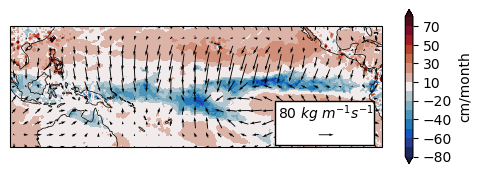

In [3]:
fig, ax = plot_setup()

## plot divergence
cp = ax.contourf(
    ivt.lon,
    ivt.lat,
    ivt["divergence"],
    transform=ccrs.PlateCarree(),
    cmap="cmo.balance",
    levels=make_cb_range(80, 10),
    extend="both",
)

## plot divergent component of flux
ax = plot_vectors(ax=ax, u_data=ivt["u_chi"], v_data=ivt["v_chi"], n=6, scale=2000)

cb = fig.colorbar(cp, label="cm/month")